**Run these cells once, no need to run them again and again.**

In [ ]:
%pip install -U diffusers datasets transformers accelerate ftfy pyarrow==9.0.0
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126

Logging in with token

In [2]:
from huggingface_hub import notebook_login, whoami

notebook_login()
#whoami()

Git-LFS installation

In [ ]:
!git lfs install
!git config --global credential.helper store

**Setup, run this cell once per new kernel** (imports, helpers, device). Pip/login/git lfs above are one-time.

In [1]:
import numpy as np
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
import torchvision
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image

# Quick CUDA check (optional)
print("CUDA:", torch.cuda.is_available(), "| device count:", torch.cuda.device_count())


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA: True | device count: 1


Loading the model pipeline for "Mr. Potatohead"

In [ ]:
from diffusers import StableDiffusionPipeline

# Check out https://huggingface.co/sd-dreambooth-library for loads of models from the community
model_id = "sd-dreambooth-library/mr-potato-head"

# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    device
)

Generating images with the pipeline

  0%|          | 0/60 [00:00<?, ?it/s]

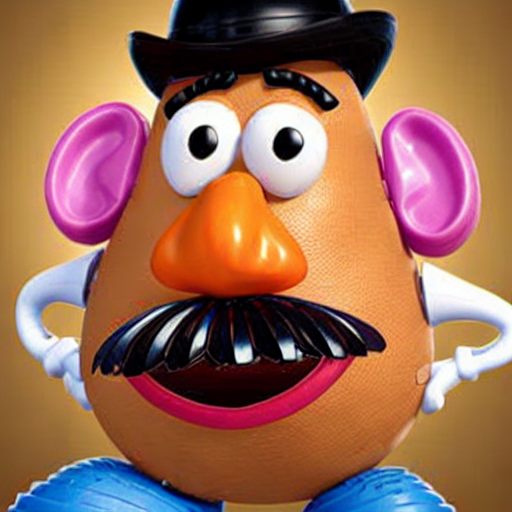

In [8]:
prompt = "a detailed studio photo of mr potato head, no hat, sad expression"
negative_prompt = "blurry, low quality, distorted, deformed, artifacts"

image = pipe(
    prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=60,   # 50→60
    guidance_scale=7.5,       # 9→7.5
).images[0]
image

Generating butterflies with DDPMPipeline

In [2]:
from diffusers import DDPMPipeline

# Load the butterfly pipeline
butterfly_pipeline = DDPMPipeline.from_pretrained(
    "johnowhitaker/ddpm-butterflies-32px"
).to(device)

# Create 8 images
images = butterfly_pipeline(batch_size=8).images

# View the result
make_grid(images)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch C:\Users\kerem\.cache\huggingface\hub\models--johnowhitaker--ddpm-butterflies-32px\snapshots\ff99059aed185f6158729b8e9f2286c4b9c177f3: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\kerem\.cache\huggingface\hub\models--johnowhitaker--ddpm-butterflies-32px\snapshots\ff99059aed185f6158729b8e9f2286c4b9c177f3.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Downloading a training dataset.

In [2]:
import torchvision
import torch
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

# Or load images from a local folder
#dataset = load_dataset("ceyda/smithsonian_butterflies", split="train")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 128

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True # Speeds up transfer from RAM to GPU
)

Repo card metadata block was not found. Setting CardData to empty.


Viewing some samples from dataset 

X shape: torch.Size([8, 3, 32, 32])


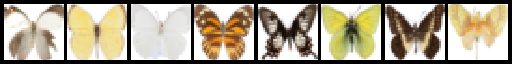

In [3]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

Scheduler, I can change the number of timesteps, higher is slower but better in quality.
Scheduler parameters

- **num_train_timesteps**: Total number of noise steps (e.g. 1000).
- **beta_schedule**: How $\beta_t$ is chosen. `"linear"` (default) or `"squaredcos_cap_v2"` (cosine).
- **$\alpha_t$ (alpha):** $\alpha_t = 1 - \beta_t$. At each timestep it controls how much signal is kept vs. noise added. $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$ is the cumulative product and scales the original image in $x_t$.
- **Plot:** $\sqrt{\bar{\alpha}_t}$ = signal scale, $\sqrt{1-\bar{\alpha}_t}$ = noise scale; x-axis is timestep $t$.


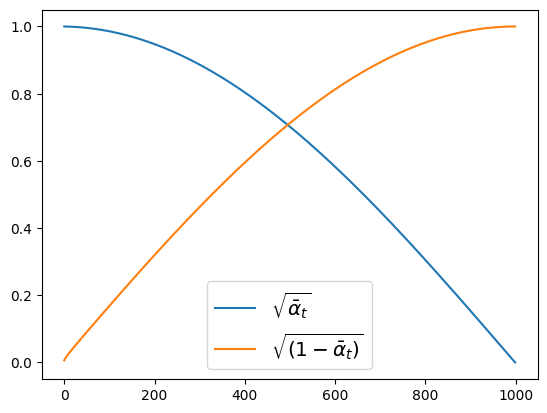

In [ ]:
from diffusers import DDPMScheduler

# noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

Effect of the noise scheduler

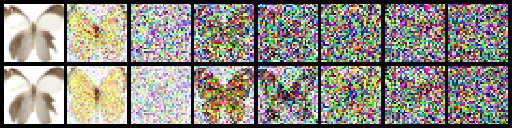

In [ ]:
scheduler1 = DDPMScheduler(num_train_timesteps=1000, beta_schedule= "linear")
scheduler2 = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)

noisy_xb1 = scheduler1.add_noise(xb, noise, timesteps)

noisy_xb2 = scheduler2.add_noise(xb, noise, timesteps)

combined = torch.cat([noisy_xb1, noisy_xb2], dim=0)
show_images(combined).resize((8 * 64, 128), resample=Image.NEAREST) 

Adding noise to batch xb, with respect to scheduler.

Noisy X shape torch.Size([8, 3, 32, 32])


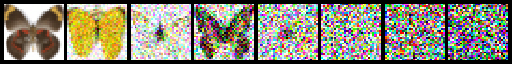

In [5]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

Defining the model.

In [5]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

Training loop

In [10]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

Epoch:5, loss: 0.18275297060608864
Epoch:10, loss: 0.1560902539640665
Epoch:15, loss: 0.13007053080946207
Epoch:20, loss: 0.11560267396271229
Epoch:25, loss: 0.09990465361624956
Epoch:30, loss: 0.09857593476772308


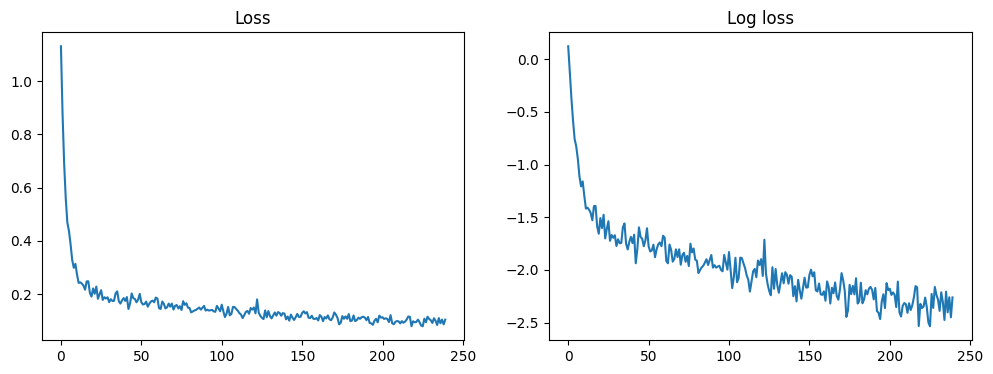

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(np.array(losses) + 1e-8))
axs[0].set_title("Loss")
axs[1].set_title("Log loss")
plt.show()

Creating a pipeline to generate images

In [12]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

  0%|          | 0/1000 [00:00<?, ?it/s]

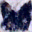

In [13]:
pipeline_output = image_pipe()
pipeline_output.images[0]

In [15]:
image_pipe.save_pretrained("pipeline_unit_1")

Importing the pipeline

In [7]:
from diffusers import DDPMPipeline

pipe = DDPMPipeline.from_pretrained(
    "pipeline_unit_1",
    local_files_only=True
).to(device)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Reverse diffusion

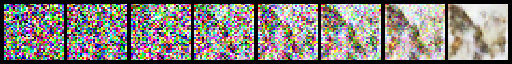

In [ ]:
# Reverse diffusion
num_inference_steps = 1000
pipe.scheduler.set_timesteps(num_inference_steps)

sample = torch.randn_like(xb[:1]).to(device)

n_frames = 8
frame_indices = torch.linspace(0, num_inference_steps - 1, n_frames).long().tolist()

frames = []

with torch.no_grad():
    for i, t in enumerate(pipe.scheduler.timesteps):
        model_output = pipe.unet(sample, t).sample

        sample = pipe.scheduler.step(model_output, t, sample).prev_sample

        if i in frame_indices:
            frames.append(sample.detach().cpu()[0])

frames_to_show = torch.stack(frames, dim=0)
show_images(frames_to_show).resize((n_frames * 64, 64), resample=Image.NEAREST)

Generating images with our pipeline

  0%|          | 0/1000 [00:00<?, ?it/s]

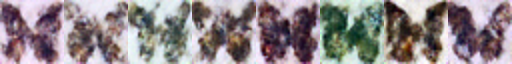

In [8]:

images = pipe(batch_size=8).images

make_grid(images)

In [13]:
from huggingface_hub import get_full_repo_name

model_name = "butterflies-sd-32"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'keremaslan/butterflies-sd-32'

In [16]:
from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id, exist_ok=True)
api = HfApi()
api.upload_folder(
    folder_path="pipeline_unit_1/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(folder_path="pipeline_unit_1/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="pipeline_unit_1/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/keremaslan/butterflies-sd-32/commit/b6a5cee1206270b6368d8955c9bb8c9390416cdb', commit_message='Upload model_index.json with huggingface_hub', commit_description='', oid='b6a5cee1206270b6368d8955c9bb8c9390416cdb', pr_url=None, repo_url=RepoUrl('https://huggingface.co/keremaslan/butterflies-sd-32', endpoint='https://huggingface.co', repo_type='model', repo_id='keremaslan/butterflies-sd-32'), pr_revision=None, pr_num=None)

In [18]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image"""

In [19]:
card = ModelCard(content)
card.push_to_hub(hub_model_id)

CommitInfo(commit_url='https://huggingface.co/keremaslan/butterflies-sd-32/commit/a870d9b938f4aeae3487259bef59e9bd600d6aa6', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='a870d9b938f4aeae3487259bef59e9bd600d6aa6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/keremaslan/butterflies-sd-32', endpoint='https://huggingface.co', repo_type='model', repo_id='keremaslan/butterflies-sd-32'), pr_revision=None, pr_num=None)